Hi, we wish to start pertaining homework #2. 

## **Theoretical section** 

In [1]:
from IPython.display import IFrame, display
filepath = "Theoretical_part_hw2.pdf"
IFrame(filepath, width=700, height=1000)


## **Practical Section**


#### Q1:

Importing the data 

In [2]:
import pandas as pd 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold as SKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler as stsc
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.decomposition import PCA
filepath = Path.cwd().joinpath('HW2_data.csv')
T1D = pd.read_csv(filepath)

Now we want to exclude patients that did not answer all the questions. and then assign the Diagnosis to a distinct dataframe

In [3]:
T1D_raw_exnan = T1D.dropna()  
diagnosis = T1D_raw_exnan['Diagnosis']
diagnosis = diagnosis.replace('Positive', True).replace('Negative', False)
age = T1D_raw_exnan['Age']
feat_col = set(T1D_raw_exnan.columns)
feat_col.remove('Diagnosis')
T1D_exnan_age = T1D_raw_exnan[feat_col]
T1D_exnan_age = T1D_raw_exnan[feat_col]
T1D_exnan_age = T1D_exnan_age.replace('Yes', 1)
T1D_exnan_age = T1D_exnan_age.replace('No', 0)
T1D_exnan_age = T1D_exnan_age.replace('Female', 1)
T1D_exnan_age = T1D_exnan_age.replace('Male', 0)
feat_col.remove('Age')
T1D_exnan = T1D_exnan_age[feat_col]

##### explanation for preprocessing:

we have ommitted every patient that has a NaN feature. we should check that this doesn't affect the distribution and force a bias. furthermore, for simplicity we turned the data into numeric values, yes to 1 no to 0, and Gender as well, 1 to female 0 to male (Done that before reading Q4). and diagnosis Vector turned into True and False

#### **Q2:**
Perfroming test-train split

In [4]:
xtr, xte, ytr, yte = tts(T1D_exnan, np.ravel(diagnosis), test_size=0.2, random_state=7, stratify=np.ravel(diagnosis))

#### **Q3:**
Visualization and exploration of the data:

**3. a.**

In [5]:
vis_table = pd.DataFrame(index=feat_col, columns=['Train [%]', 'Test [%]', 'Delta [%]'])
for ii, col in enumerate(feat_col):
    vis_table.loc[col, 'Train [%]'] = 100 * xtr[col].sum() / xtr[col].count()
    vis_table.loc[col, 'Test [%]'] = 100 * xte[col].sum() / xte[col].count()
    vis_table.loc[col, 'Delta [%]'] = vis_table.loc[col, 'Train [%]'] - vis_table.loc[col, 'Test [%]']
vis_table=vis_table.rename_axis('Positive Feature', axis=1)
display(vis_table)

Positive Feature,Train [%],Test [%],Delta [%]
Hair Loss,33.9713,37.1429,-3.17157
Sudden Weight Loss,41.3876,41.9048,-0.517202
Partial Paresis,42.823,42.8571,-0.0341763
Increased Thirst,44.2584,45.7143,-1.45591
Family History,50.4785,52.381,-1.90248
Gender,37.799,33.3333,4.46571
Genital Thrush,21.2919,25.7143,-4.42242
Irritability,23.445,27.619,-4.17407
Muscle Stiffness,37.5598,36.1905,1.36933
Increased Urination,48.5646,53.3333,-4.76874


We can see that the the representation of the various features are very similar in the train and test sets.

i. An imbalance of features between train and test might force a bias to the results because of under-representation or over representation to a particular phenomena that might build a model that doesn't fit the test data or correctly predict the futural data.

ii. If the medical condition is not complex, meaning that only exclusive set of sympotms are indicative/predictive for the condition, then stratifying the test-train data based on the diagnosis guarantees balanced representation of these features, meaning we can ignore other features that are imbalanced. For more complex datasets, we should try to stratify the data based on the features, i.e. looking at the n-dimesional distribution and try to split the data in a balanced way along with trying to balance the diagnosis.


**3. b.** in order to observe the relationship between features and labels we've constructed:

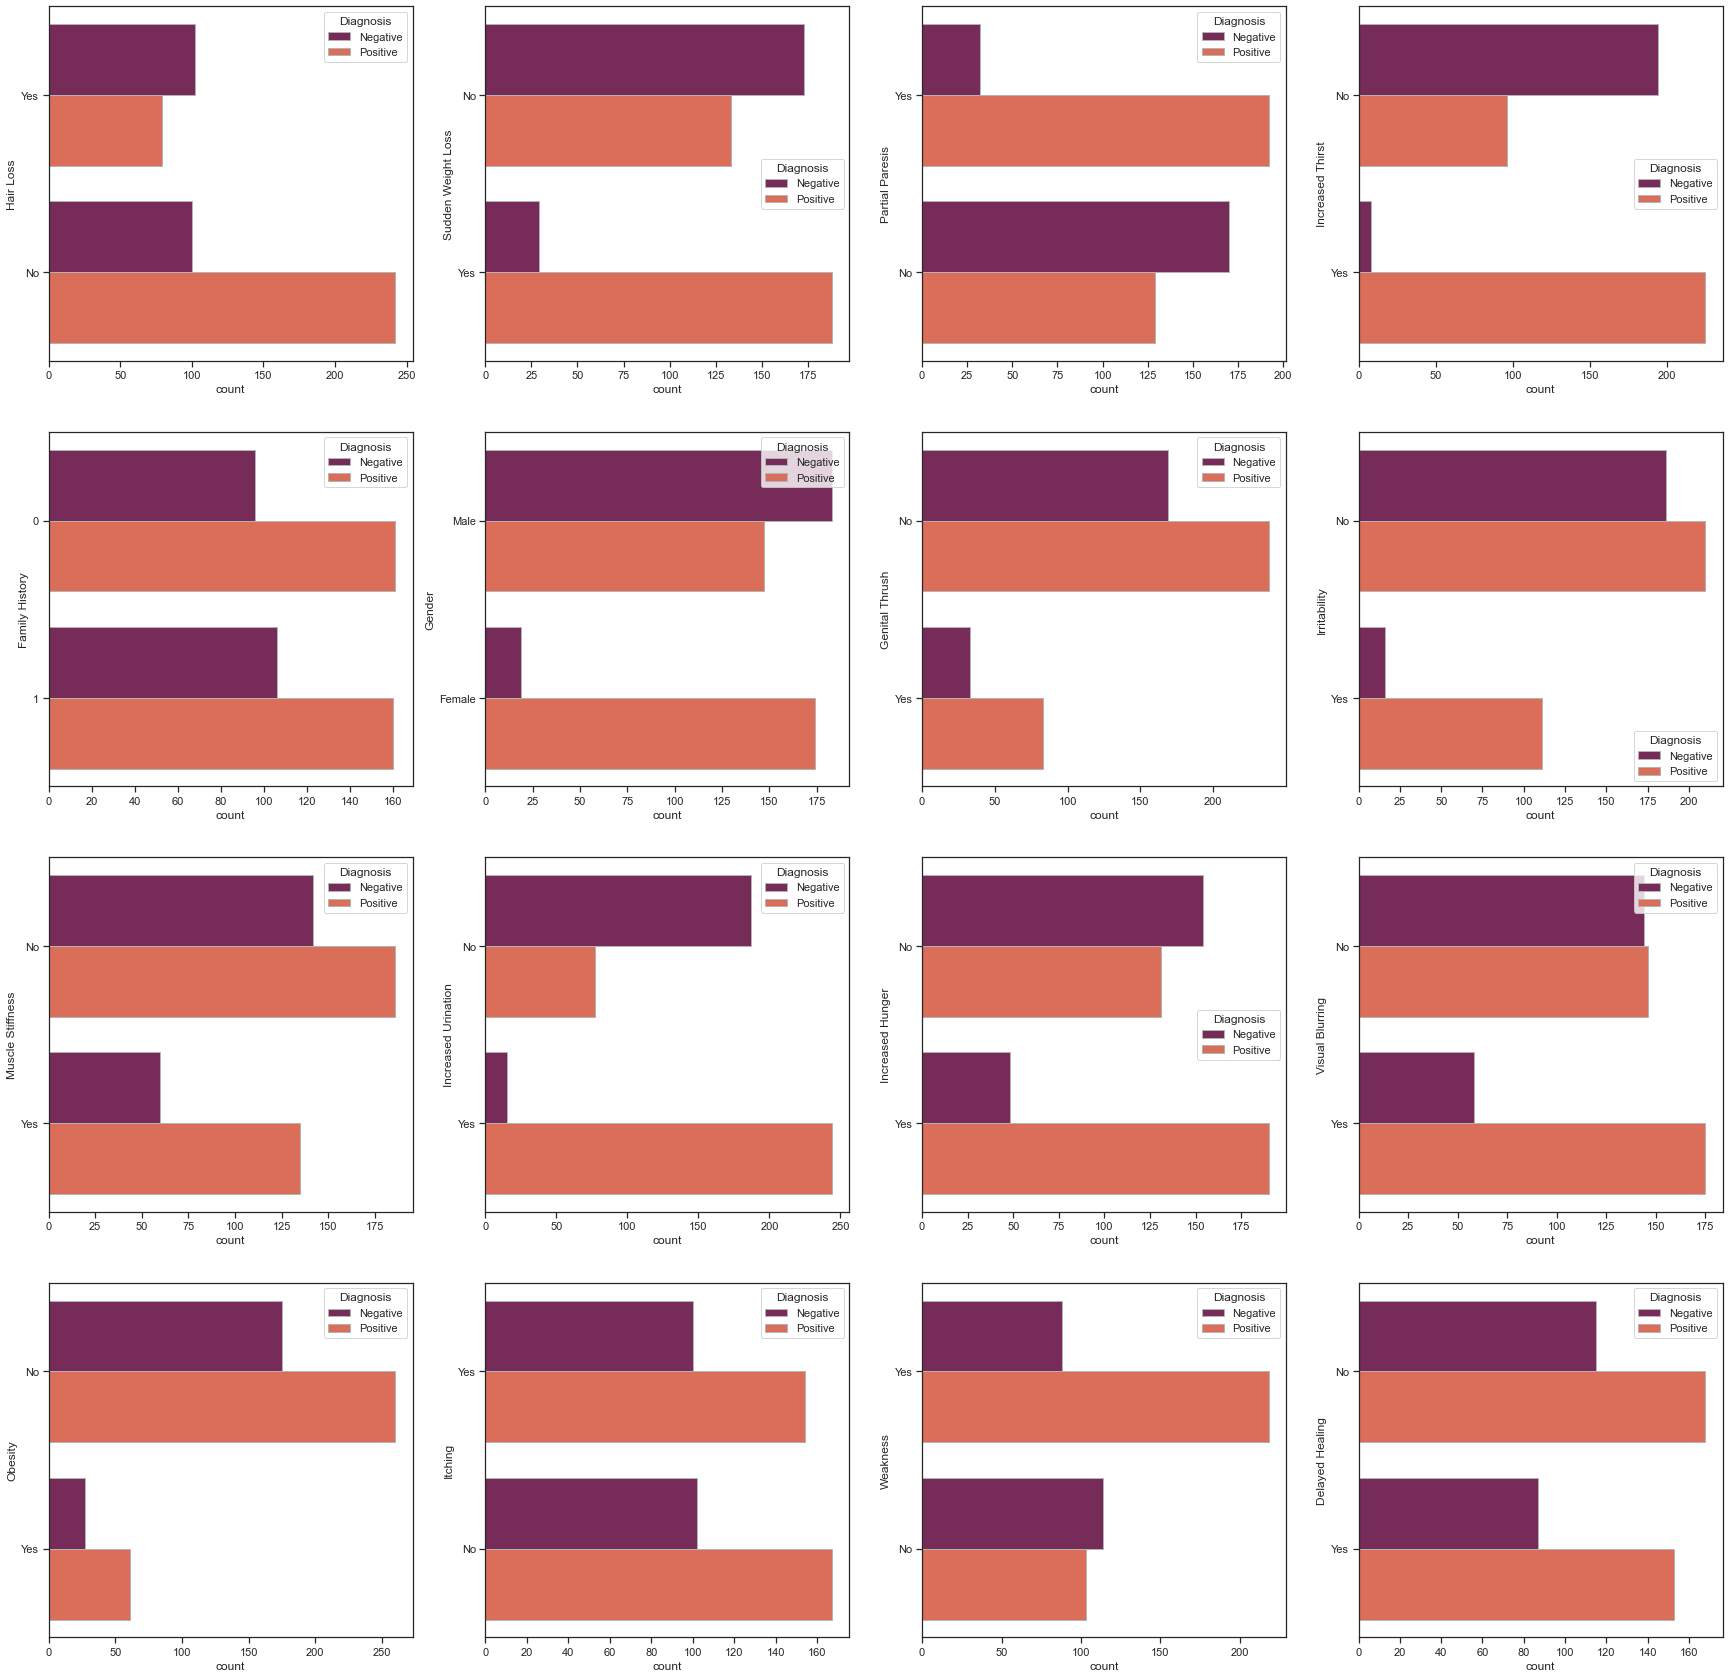

In [6]:
fig = plt.figure(figsize=(30,30))
sns.set_theme(style="ticks", color_codes=True)
for ii, col in enumerate(feat_col):
    ax = fig.add_subplot(4,4,ii+1)
    plot = sns.countplot(y=col, hue="Diagnosis", data=T1D_raw_exnan, palette="rocket", edgecolor=".7",ax=ax)

Further, in the next plot we wanted to find any correlation between age and diagnosis, since the Age data is not binary, and further discriminated between females and males in order to observe any biases.

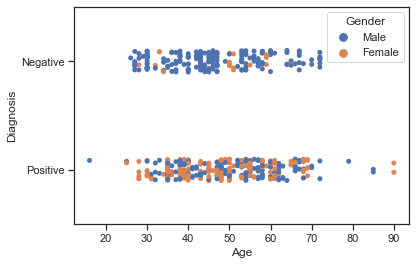

In [7]:
fig = plt.figure()
plot = sns.stripplot(x="Age", y="Diagnosis", hue="Gender", data=T1D_raw_exnan)

3. d. i. first, we noticed that nearly all the females in this dataset have T1D, which might bias the model/predictions. afterwards we further investigated the countplots with two different perspectives: 

    1- Picking the symptoms (features) that are present mainly in the T1D positive patients (https://www.mayoclinic.org/diseases-conditions/type-1-diabetes/symptoms-causes/syc-20353011), we see that if the symptom is present, most probably the patient is T1D-positive. 

    2- looking at the positives patients and noticing that not all of them are showing the same symptoms, meaning that there is a T1D-positive patient that doesn't suffer from increased-thirst for instance. you may look at visual blurring symptom, we can see that there is nearly 50-50 partition in T1D-postivie patietns. Meaning, a model based mainly on this feature is not sensitive enough and will miss-classify a significant amount of T1D-positive patients.

3. d. ii. Yes, we scanned the categorical plots above and searched for large gaps between Negative and Positive diagnosis correlated with specific features. For instance, look at **Increased Urination**, where you can see that most of the participants that have this symptom are positive for T1D so we can infer that this symptom is indicative/predictive for T1D. other than **Increased Urination**, there are: **Increased Hunger**, **Increased Thirst**, **Irritibaility**, **Prtial Paresis** and **Visual Paresis**.

#### **Q4:**
We have already done the transformation for hot vectors manually, as we binarized the yes/no dataset. We decided to neglect the Age feature at first, due to a broad distribution that might be detrimental for the performance, and we furhter corroborated the decision by showing above that there is no clear observed correlation between Age and Diagnosis. to observe our manual work excluding age feature: 

In [8]:
display(T1D_exnan)

,Hair Loss,Sudden Weight Loss,Partial Paresis,Increased Thirst,Family History,Gender,Genital Thrush,Irritability,Muscle Stiffness,Increased Urination,Increased Hunger,Visual Blurring,Obesity,Itching,Weakness,Delayed Healing
0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1
3,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,0,1,0,0,1,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,1,0,1,0,0,0,1,1,1,1,0,1,1,1,1,0
519,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,1
562,1,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0
563,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


Notwithstanding, we decided to test whether the age criteria might influence the model, we will include it in a parallel analysis, here we encode the whole data with one-hot vectors as offered by sklearn (pseudo-binarized the age feature, by trnasforming it for multiple 'pseudo-features'- every bit in the age sub-field indicates one number).

In [9]:
onehot = OneHotEncoder(handle_unknown='ignore')
onehot.fit(T1D_exnan_age)
T1D_exnan_age_oh = onehot.transform(T1D_exnan_age)
T1D_exnan_age_oh = pd.DataFrame(T1D_exnan_age_oh.toarray())
display(T1D_exnan_age_oh)

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
519,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
520,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
521,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In order to input the one-hot vectors to the model construction, we would like to stratify it for train and test data accordingly to the same random_state we have already done

In [10]:
xtr_age, xte_age, ytr_age, yte_age = tts(T1D_exnan_age_oh, np.ravel(diagnosis), test_size=0.2, random_state=7, stratify=np.ravel(diagnosis))

#### **Q5:**
5. a. We will apply two different models starting with a linear model: Logistic regression.

In [11]:
L = 120
K = 5
C = np.linspace(3/L, 3, L)
C[0] = 0.000001
indnum = L*2
penalty = ['l1','l2']
se, sp = np.zeros((L,1)), np.zeros((L,1))
fig = plt.figure(figsize=(30,30))
kf = SKFold(n_splits=K)
validation_dict_lr = []
validation_dict_age_lr = []
valdf_lr = pd.DataFrame(columns=('C', 'penalty', 'AUC', 'ACC', 'LogLoss', 'F1'))
valdf_age_lr = pd.DataFrame(columns=('C', 'penalty', 'AUC', 'ACC', 'LogLoss', 'F1'))
ind = 0
for ii, cc in enumerate(C):
        for p in penalty:
            logloss, logloss_age = np.zeros(K), np.zeros(K)
            acc, acc_age = np.zeros(K), np.zeros(K)
            auc, auc_age = np.zeros(K), np.zeros(K)
            f1, f1_age = np.zeros(K), np.zeros(K)
            k = 0
            for train_idx, val_idx in kf.split(xtr, ytr):
                x_train, x_val, x_age_train, x_age_val = xtr.iloc[train_idx], xtr.iloc[val_idx], xtr_age.iloc[train_idx], xtr_age.iloc[val_idx]
                logreg = LogisticRegression(solver='saga', penalty=p, max_iter=10000, C=cc)
                logreg_age = LogisticRegression(solver='saga', penalty=p, max_iter=10000, C=cc)
                logreg.fit(x_train, ytr[train_idx])
                logreg_age.fit(x_age_train, ytr_age[train_idx])
                y_pred_log, y_age_pred_log = logreg.predict(x_val), logreg_age.predict(x_age_val)
                y_predproba_log, y_age_predproba_log = logreg.predict_proba(x_val), logreg_age.predict_proba(x_age_val)
                y_val_log, y_age_val_log = ytr[val_idx], ytr_age[val_idx]
                acc[k], acc_age[k] = metrics.accuracy_score(y_val_log, y_pred_log), metrics.accuracy_score(y_age_val_log, y_age_pred_log)
                f1[k], f1_age[k] = metrics.f1_score(y_val_log, y_pred_log), metrics.f1_score(y_age_val_log, y_age_pred_log)
                logloss[k], logloss_age[k] = metrics.log_loss(y_val_log, y_predproba_log), metrics.log_loss(y_age_val_log, y_age_predproba_log)
                auc[k], auc_age[k] = metrics.roc_auc_score(y_val_log, y_predproba_log[:,1]), metrics.roc_auc_score(y_age_val_log, y_age_predproba_log[:,1]) 
                k+=1
            validation_dict_lr.append({'C': cc, 'penalty': p, 'logloss' : logloss.mean(), 'Accuracy' : acc.mean(), 'F1' : f1.mean(),
                                   'AUC' : auc.mean()})
            validation_dict_lr.append({'C': cc, 'penalty': p, 'logloss' : logloss_age.mean(), 'Accuracy' : acc_age.mean(), 'F1' : f1_age.mean(),
                                   'AUC' : auc_age.mean()})            
            valdf_lr.loc[ind, :] = cc, p, auc.mean(), acc.mean(), logloss.mean(), f1.mean()
            valdf_age_lr.loc[ind, :] = cc, p, auc_age.mean(), acc_age.mean(), logloss_age.mean(), f1_age.mean()
            ind+=1
            

<Figure size 2160x2160 with 0 Axes>

In [12]:
display(valdf_lr)

,C,penalty,AUC,ACC,LogLoss,F1
0,1e-06,l1,0.5,0.614831,0.670326,0.761471
1,1e-06,l2,0.931582,0.614831,0.66654,0.761471
2,0.05,l1,0.939332,0.851434,0.405501,0.873607
3,0.05,l2,0.958847,0.88973,0.351774,0.909689
4,0.075,l1,0.93884,0.875301,0.350019,0.900933
...,...,...,...,...,...,...
235,2.95,l2,0.967815,0.925674,0.216197,0.938708
236,2.975,l1,0.968331,0.911388,0.21843,0.926859
237,2.975,l2,0.967815,0.925674,0.216177,0.938708
238,3,l1,0.968331,0.911388,0.218457,0.926859


(0.45, 1.0)

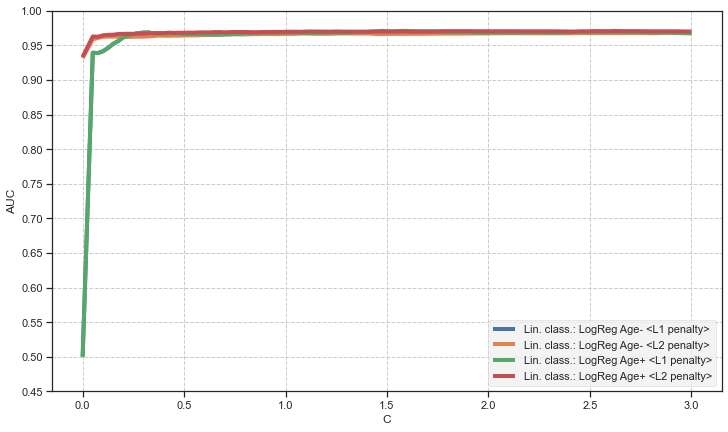

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))
mpl.style.use('fivethirtyeight')
plt1=plt.plot(valdf_lr['C'].loc[valdf_lr['penalty']=='l1'], valdf_lr['AUC'].loc[valdf_lr['penalty']=='l1'], label='Lin. class.: LogReg Age- <L1 penalty>')
plt2=plt.plot(valdf_lr['C'].loc[valdf_lr['penalty']=='l2'], valdf_lr['AUC'].loc[valdf_lr['penalty']=='l2'], label='Lin. class.: LogReg Age- <L2 penalty>')
plt3=plt.plot(valdf_age_lr['C'].loc[valdf_age_lr['penalty']=='l1'], valdf_age_lr['AUC'].loc[valdf_age_lr['penalty']=='l1'], label='Lin. class.: LogReg Age+ <L1 penalty>')
plt4=plt.plot(valdf_age_lr['C'].loc[valdf_age_lr['penalty']=='l2'], valdf_age_lr['AUC'].loc[valdf_age_lr['penalty']=='l2'], label='Lin. class.: LogReg Age+ <L2 penalty>')
plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.set_ylim(0.45, 1)

**untill now, we conducted manual parameter tuning and observed the above graph and noticed that the best model would be without taking into consideration the Age feature and using L2 penalty (for the logistic regression model). Now we want to apply an objective and automatic model selection based on GridSearchCV, also two parallel computations with and without age feature.**

##### Excluding the Age feature:

In [14]:
estimator_lr = LogisticRegression(solver='saga', max_iter=10000)
params_dict = {
    'C'      : np.linspace(0.01, 3, 100), 
    'penalty'  : ['l1', 'l2']
}
clf_lr = GridSearchCV(estimator_lr, params_dict, scoring='roc_auc')
clf_lr.fit(xtr, ytr)
clf_lr.best_estimator_
best_lr = clf_lr.best_params_

In [15]:
print("Best parameters: C= " + str("{0:.2f}".format(best_lr['C'])) + 
      ", penalty=" + str(best_lr['penalty']) + " with score="  + str("{0:.5f}".format(clf_lr.best_score_)))

Best parameters: C= 1.58, penalty=l1 with score=0.96929


##### Including the Age feature:

In [16]:
estimator_lr_age = LogisticRegression(solver='saga', max_iter=10000)
params_dict = {
    'C'      : np.linspace(0.01, 3, 100), 
    'penalty'  : ['l1', 'l2']
}
clf_lr_age = GridSearchCV(estimator_lr_age, params_dict, scoring='roc_auc')
clf_lr_age.fit(xtr_age, ytr_age)
clf_lr_age.best_estimator_
best_lr_age = clf_lr_age.best_params_

In [17]:
print("Best parameters: C = " + str("{0:.2f}".format(best_lr_age['C'])) + 
      ", penalty = " + str(best_lr_age['penalty']) + " with score="  + str("{0:.5f}".format(clf_lr_age.best_score_)))

Best parameters: C= 1.58, penalty=l1 with score=0.97098


##### Next, we will apply a non-linear model to the dataset -> SVM:  #####

In [18]:
L = 120
K = 5
C = np.linspace(3/L, 3, L)
C[0] = 0.000001
kernel=['linear', 'poly', 'rbf', 'sigmoid']
indnum = L*np.shape(kernel)
se, sp = np.zeros((L,1)), np.zeros((L,1))
fig = plt.figure(figsize=(30,30))
kf = SKFold(n_splits=K)
validation_dict_svm = []
validation_age_dict_svm = []
valdf_svm = pd.DataFrame(columns=('C', 'kernel', 'AUC', 'ACC', 'Hinge Loss', 'F1'))
valdf_age_svm = pd.DataFrame(columns=('C', 'kernel', 'AUC', 'ACC', 'Hinge Loss', 'F1'))
ind = 0
for ii, cc in enumerate(C):
        for kk in kernel:
            hingeloss, hingeloss_age = np.zeros(K), np.zeros(K)
            acc, acc_age = np.zeros(K), np.zeros(K)
            auc, auc_age = np.zeros(K), np.zeros(K)
            f1, f1_age = np.zeros(K), np.zeros(K)
            k = 0
            for train_idx, val_idx in kf.split(xtr, ytr):
                x_train, x_val, x_age_train, x_age_val = xtr.iloc[train_idx], xtr.iloc[val_idx], xtr_age.iloc[train_idx], xtr_age.iloc[val_idx]
                clf = svm.SVC(C=cc, kernel=kk, probability=True)
                clf_age = svm.SVC(C=cc, kernel=kk, probability=True)
                clf.fit(x_train, ytr[train_idx])
                clf_age.fit(x_age_train, ytr_age[train_idx])
                y_pred_svm = clf.predict(x_val)
                y_predproba_svm = clf.predict_proba(x_val)
                y_age_pred_svm = clf_age.predict(x_age_val)
                y_age_predproba_svm = clf_age.predict_proba(x_age_val)
                y_val_svm, y_age_val_svm = ytr[val_idx], ytr_age[val_idx]
                acc[k], acc_age[k] = metrics.accuracy_score(y_val_svm, y_pred_svm), metrics.accuracy_score(y_age_val_svm, y_age_pred_svm)
                f1[k], f1_age[k] = metrics.f1_score(y_val_svm, y_pred_svm), metrics.f1_score(y_age_val_svm, y_age_pred_svm)
                hingeloss[k], hingeloss_age[k] = metrics.hinge_loss(y_val_svm, y_pred_svm), metrics.hinge_loss(y_age_val_svm, y_age_pred_svm)
                auc[k], auc_age[k] = metrics.roc_auc_score(y_val_svm,  y_predproba_svm[:,1]), metrics.roc_auc_score(y_age_val_svm, y_age_predproba_svm[:,1])
                k+=1
            validation_dict_svm.append({'C': cc, 'kernel': kk, 'Hinge Loss' : logloss.mean(), 'Accuracy' : acc.mean(), 'F1' : f1.mean(),
                                   'AUC' : auc.mean()})
            validation_age_dict_svm.append({'C': cc, 'kernel': kk, 'Hinge Loss' : logloss_age.mean(), 'Accuracy' : acc_age.mean(), 'F1' : f1_age.mean(),
                                   'AUC' : auc_age.mean()})
            valdf_svm.loc[ind, :] = cc, kk, auc.mean(), acc.mean(), hingeloss.mean(), f1.mean()
            valdf_age_svm.loc[ind, :] = cc, kk, auc_age.mean(), acc_age.mean(), hingeloss_age.mean(), f1_age.mean()
            ind+=1
            

<Figure size 2160x2160 with 0 Axes>

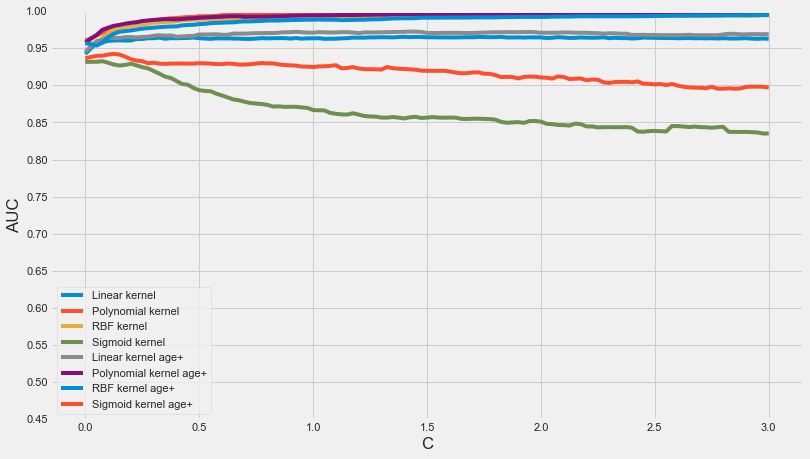

In [19]:
fig2, ax2 = plt.subplots(figsize=(12, 7))
plt5 = plt.plot(valdf_svm['C'].loc[valdf_svm['kernel']=='linear'], valdf_svm['AUC'].loc[valdf_svm['kernel']=='linear'], label='Linear kernel')
plt6 = plt.plot(valdf_svm['C'].loc[valdf_svm['kernel']=='poly'], valdf_svm['AUC'].loc[valdf_svm['kernel']=='poly'], label='Polynomial kernel')
plt7 = plt.plot(valdf_svm['C'].loc[valdf_svm['kernel']=='rbf'], valdf_svm['AUC'].loc[valdf_svm['kernel']=='rbf'], label='RBF kernel')
plt8 = plt.plot(valdf_svm['C'].loc[valdf_svm['kernel']=='sigmoid'], valdf_svm['AUC'].loc[valdf_svm['kernel']=='sigmoid'], label='Sigmoid kernel')
plt5 = plt.plot(valdf_age_svm['C'].loc[valdf_age_svm['kernel']=='linear'], valdf_age_svm['AUC'].loc[valdf_age_svm['kernel']=='linear'], label='Linear kernel age+')
plt6 = plt.plot(valdf_age_svm['C'].loc[valdf_age_svm['kernel']=='poly'], valdf_age_svm['AUC'].loc[valdf_age_svm['kernel']=='poly'], label='Polynomial kernel age+')
plt7 = plt.plot(valdf_age_svm['C'].loc[valdf_age_svm['kernel']=='rbf'], valdf_age_svm['AUC'].loc[valdf_age_svm['kernel']=='rbf'], label='RBF kernel age+')
plt8 = plt.plot(valdf_age_svm['C'].loc[valdf_age_svm['kernel']=='sigmoid'], valdf_age_svm['AUC'].loc[valdf_age_svm['kernel']=='sigmoid'], label='Sigmoid kernel age+')
mpl.style.use('fivethirtyeight')
plt.xlabel('C')
plt.ylabel('AUC')
ax2.yaxis.set_major_locator(MultipleLocator(0.05))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax2.set_ylim(0.45, 1)
plt.legend()

Now, after we've done the preliminary comparison of the SVM models (based on their various kernels and varying C), we want to further test the complex kernels (poly, rbf, sigmoid) which leverage another hyperparameter- Gamma.

**excluding age feature**:

In [20]:
estimator_svm = svm.SVC()
params_dict = {
    'kernel' : ['poly', 'sigmoid', 'rbf'], 
    'C'      : np.linspace(0.01, 3, 100), 
    'gamma'  : np.linspace(0.01, 3, 100)
}
clf_svm = GridSearchCV(estimator_svm, params_dict, scoring='roc_auc')
clf_svm.fit(xtr, ytr)
clf_svm.best_estimator_
best_svm = clf_svm.best_params_

In [21]:
print("Best parameters: C = " + str("{0:.2f}".format(best_svm['C'])) + " gamma= " + str("{0:.2f}".format(best_svm['gamma'])) +
      ", kernel=" + best_svm['kernel'] + " with score="  + str("{0:.5f}".format(clf_svm.best_score_)))

Best parameters: C = 2.64 gamma= 0.31, kernel=rbf with score=0.99623


**including age feature**:

In [23]:
estimator_svm_age = svm.SVC()
params_dict = {
    'kernel' : ['poly', 'sigmoid', 'rbf'], 
    'C'      : np.linspace(0.01, 3, 100), 
    'gamma'  : np.linspace(0.01, 3, 100),
}
clf_svm_age = GridSearchCV(estimator_svm_age, params_dict)
clf_svm_age.fit(xtr_age, ytr_age)
clf_svm_age.best_estimator_
best_svm_age = clf_svm_age.best_params_

In [25]:
print("Best parameters: C = " + str("{0:.2f}".format(best_svm_age['C'])) + ", gamma = " + str("{0:.2f}".format(best_svm_age['gamma'])) +
      ", kernel=" + str(best_svm_age['kernel']) + " with score="  + str("{0:.5f}".format(clf_svm_age.best_score_)))

Best parameters: C = 1.25, gamma = 0.28, kernel=rbf with score=0.98087


In [ ]:
#In order to observe the contrast we shall overlay the AUC plots

In [ ]:
#from collections import OrderedDict
#fig, ax = plt.subplots(figsize=(12, 7))
#mpl.style.use('fivethirtyeight')
#ax.set_title('Receiver-operator AUC of all Classifiers'.format('seaborn'), color='C3')
#plt1 = plt.plot(valdf_lr['C'].loc[valdf_lr['penalty']=='l1'], valdf_lr['AUC'].loc[valdf_lr['penalty']=='l1'], label='Lin. class.:: LogReg Age- <L1 penalty>', color = 'darkkhaki')
#plt2 = plt.plot(valdf_lr['C'].loc[valdf_lr['penalty']=='l2'], valdf_lr['AUC'].loc[valdf_lr['penalty']=='l2'], label='Lin. class.:: LogReg Age- <L2 penalty>', color = 'olive')
#plt3 = plt.plot(valdf_age_lr['C'].loc[valdf_age_lr['penalty']=='l1'], valdf_age_lr['AUC'].loc[valdf_age_lr['penalty']=='l1'], label='Lin. class.: LogReg Age+ <L1 penalty>', color = 'mediumseagreen')
#plt4 = plt.plot(valdf_age_lr['C'].loc[valdf_age_lr['penalty']=='l2'], valdf_age_lr['AUC'].loc[valdf_age_lr['penalty']=='l2'], label='Lin. class.: LogReg Age+ <L2 penalty>', color = 'darkgreen')
#plt5 = plt.plot(valdf_svm['C'].loc[valdf_svm['kernel']=='linear'], valdf_svm['AUC'].loc[valdf_svm['kernel']=='linear'], label='Nonlin. class.:: SVM Age- <Lin. kernel>', color = 'aquamarine')
#plt6 = plt.plot(valdf_svm['C'].loc[valdf_svm['kernel']=='poly'], valdf_svm['AUC'].loc[valdf_svm['kernel']=='poly'], label='Nonlin. class.:: SVM Age- <Poly. kernel>', color = 'turquoise')
#plt7 = plt.plot(valdf_svm['C'].loc[valdf_svm['kernel']=='rbf'], valdf_svm['AUC'].loc[valdf_svm['kernel']=='rbf'], label='Nonlin. class.:: SVM Age- <RBF kernel>', color = 'lightseagreen')
#plt8 = plt.plot(valdf_svm['C'].loc[valdf_svm['kernel']=='sigmoid'], valdf_svm['AUC'].loc[valdf_svm['kernel']=='sigmoid'], label='Nonlin. class.:: SVM Age- <Sigm. kernel>', color = 'darkcyan')
#plt9 = plt.plot(valdf_age_svm['C'].loc[valdf_age_svm['kernel']=='linear'], valdf_age_svm['AUC'].loc[valdf_age_svm['kernel']=='linear'], label='Nonlin. class.:: SVM Age+ <Lin. kernel>', color = 'thistle')
#plt10 = plt.plot(valdf_age_svm['C'].loc[valdf_age_svm['kernel']=='poly'], valdf_age_svm['AUC'].loc[valdf_age_svm['kernel']=='poly'], label='Nonlin. class.:: SVM Age+ <Poly. kernel>', color = 'plum')
#plt11 = plt.plot(valdf_age_svm['C'].loc[valdf_age_svm['kernel']=='rbf'], valdf_age_svm['AUC'].loc[valdf_age_svm['kernel']=='rbf'], label='Nonlin. class.:: SVM Age+ <RBF kernel>', color = 'violet')
#plt12 = plt.plot(valdf_age_svm['C'].loc[valdf_age_svm['kernel']=='sigmoid'], valdf_age_svm['AUC'].loc[valdf_age_svm['kernel']=='sigmoid'], label='Nonlin. class.:: SVM Age+ <Sigm. kernel>', color = 'purple')
#plt.xlabel('C')
#plt.ylabel('AUC')
#ax.yaxis.set_major_locator(MultipleLocator(0.05))
#ax.grid(which='major', color='#CCCCCC', linestyle='--')
#ax.grid(which='minor', color='#CCCCCC', linestyle=':')
#ax.set_ylim(0.45, 1)    
#ax.legend()    

5. b. the interim results based on the training data are listed: note that including or excluding the Age feature gave much similar results and due to it's computational labor, we decided to neglect the age.
    

In [26]:
print("i- Lin. Class.: Logistic regression with " +  best_lr['penalty'] +" penalty and regularization parameter C = " +   str("{0:.2f}".format(best_lr['C'])))
print("ii- Nonlin. Class.: SVM classifier with " + best_svm['kernel'] +" kernel, regularization parameter C = " + str("{0:.2f}".format(best_svm['C'])) +" and gamma = " + str("{0:.2f}".format(best_svm['gamma'])))
    

i- Lin. Class.: Logistic regression with l1 penalty and regularization parameter C = 1.58
ii- Nonlin. Class.: SVM classifier with rbf kernel, regularization parameter C = 2.64 and gamma = 0.31


Next, we will report the evaluation metrics for the models mentioned above. First, we will train the models on the training set then report the metrics for classifying the train set itself. Second, we will report the metrics for the test set classification.

##### Now, let us report the metrics for classifying the two best models:

* for the linear classifier LR: 


In [27]:
C = best_lr['C']
penalty=best_lr['penalty']
testdf_lr = pd.DataFrame(index=('Train', 'Test'), columns=('C', 'penalty', 'AUC', 'ACC', 'LogLoss', 'F1'))
LR = LogisticRegression(solver='saga', penalty=penalty, max_iter=10000, C=C)
LR.fit(xtr, ytr)

y_pred_lr = LR.predict(xtr)
y_predproba_lr = LR.predict_proba(xtr)
acc = metrics.accuracy_score(ytr, y_pred_lr)
f1 = metrics.f1_score(ytr, y_pred_lr)
logloss = metrics.log_loss(ytr, y_predproba_lr)
auc = metrics.roc_auc_score(ytr,  y_predproba_lr[:,1])
testdf_lr.loc['Train', :] = C, penalty, auc, acc, logloss, f1

y_pred_lr = LR.predict(xte)
y_predproba_lr = LR.predict_proba(xte)
acc = metrics.accuracy_score(yte, y_pred_lr)
f1 = metrics.f1_score(yte, y_pred_lr)
logloss = metrics.log_loss(yte, y_predproba_lr)
auc = metrics.roc_auc_score(yte,  y_predproba_lr[:,1])
testdf_lr.loc['Test', :] = C, penalty, auc, acc, logloss, f1


display(testdf_lr)

,C,penalty,AUC,ACC,LogLoss,F1
Train,1.58051,l1,0.979336,0.933014,0.180184,0.944882
Test,1.58051,l1,0.98247,0.942857,0.165017,0.952381


note: the test set got better results from the train, which can be surprising. But, let us recall that the training and searching for the best model used a K-fold procedure and not the raw train set.    

* for the Nonlinear classifier SVM: 

In [28]:
C = best_svm['C']
kernel=best_svm['kernel']
gamma=best_svm['gamma']
testdf_svm = pd.DataFrame(index=('Train', 'Test'), columns=('C', 'kernel', 'gamma', 'AUC', 'ACC', 'HingeLoss', 'F1'))
clf_svm = svm.SVC(C=C, kernel=kernel, gamma=gamma, probability=True)
clf_svm.fit(xtr, ytr)

y_pred_svm = clf_svm.predict(xtr)
y_predproba_svm = clf_svm.predict_proba(xtr)
acc = metrics.accuracy_score(ytr, y_pred_svm)
f1 = metrics.f1_score(ytr, y_pred_svm)
hingeloss = metrics.hinge_loss(ytr, y_pred_svm)
auc = metrics.roc_auc_score(ytr,  y_predproba_svm[:,1])
testdf_svm.loc['Train', :] = C, kernel, gamma, auc, acc, hingeloss, f1

y_pred_svm = clf_svm.predict(xte)
y_predproba_svm = clf_svm.predict_proba(xte)
acc = metrics.accuracy_score(yte, y_pred_svm)
f1 = metrics.f1_score(yte, y_pred_svm)
hingeloss = metrics.hinge_loss(yte, y_pred_svm)
auc = metrics.roc_auc_score(yte,  y_predproba_svm[:,1])
testdf_svm.loc['Test', :] = C, kernel, gamma, auc, acc, hingeloss, f1


display(testdf_svm)

,C,kernel,gamma,AUC,ACC,HingeLoss,F1
Train,2.63758,rbf,0.31202,0.997728,0.995215,0.389952,0.996124
Test,2.63758,rbf,0.31202,0.984375,0.980952,0.409524,0.984615


##### 5. c. Not surprisinigly, the Nonlinear Classifier performs a bit better than the Linear Classifier. Generally, Linear classifiers are sub-type of nonlinear classifier, so usually nonlinear classifiers perform better (but  more computationally expensive). Pertaining this data of binary features, it may result in a multi-dimensional saw-like hyper-groups that may only be seperated wisely by nonlinear classifier.

#### **Q6:** Feature Selection ####

In [29]:
rfc = RFC(n_estimators=1000, criterion='gini')
rfc.fit(xtr, ytr)
y_rfc_pred = rfc.predict(xte)
rfc_acc = metrics.accuracy_score(yte, y_rfc_pred)
print("The accuracy of the random forest classifier is: " + str("{0:.5f}".format(rfc_acc)))
      

The accuracy of the random forest classifier is: 0.98095


We see that the accuracy of this model is the highest we observed so far (equal to the accuracy of the svm on test data).
Next, we will try to understand which features are of great importance and then check for correlation with the features we explored manually:

In [30]:
rfc_res = pd.DataFrame(columns = (T1D_exnan.columns))
rfc_res.loc[0,:] = rfc.feature_importances_

display(rfc_res)

,Hair Loss,Sudden Weight Loss,Partial Paresis,Increased Thirst,Family History,Gender,Genital Thrush,Irritability,Muscle Stiffness,Increased Urination,Increased Hunger,Visual Blurring,Obesity,Itching,Weakness,Delayed Healing
0,0.0452326,0.0599982,0.0492593,0.194483,0.0110446,0.127512,0.0241703,0.0375492,0.0300864,0.207715,0.0449832,0.0356454,0.0224753,0.0438019,0.0264173,0.0396261


6. a. i. The 2 most important features according to the random forest are **Increased Thirst** and **Increased Urination** (based on feature importance score provided by random forest model). If we inspect further, we can observe that the third important feature is the Gender feature, which can be explained by the bias seen beforehand- most of the Females in this dataset are T1D positive. 

    a. ii. This matches up exactly with the feature exploration we did above.

#### **Q7:** Data Separability Visualization ####



Note: using PCA to reduce dimensioms with binary data could be problematic and is not optimal. we show below the results for a scaled PCA on the binary data and a more usable method for dimensionality reduction on binary data -> Logistic PCA.

In [31]:
scaler = stsc() #standard scaling
xtr_sc = scaler.fit_transform(xtr)
xte_sc = scaler.transform(xte)

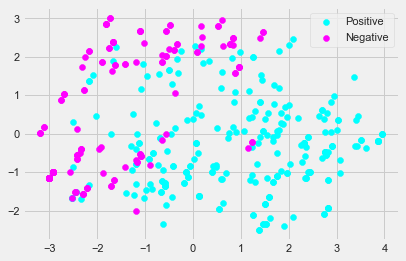

In [32]:
pca = PCA(n_components=2)
pca.fit(xtr_sc)
pca.explained_variance_ratio_
#display(pca.components_)

pca_res = pca.transform(xtr_sc)

plt.scatter(pca_res[ytr==1,0], pca_res[ytr==1,1], color='cyan', label='Positive')
plt.scatter(pca_res[ytr==0,0], pca_res[ytr==0,1], color='magenta', label='Negative')
plt.legend()

7. b. As observed in the scatter plot above, the two groups are generally distinct but are volatile and diffusive, in other words, it is apparent that there is 'geographical' seperability, but the border is blurred. Either way, a perfect separation between this two groups is not feasible using these features only.

7. c. + d. 

In [33]:
d = {'PC1': pca_res[:,0], 'PC2': pca_res[:,1], 'Diagnosis': ytr}
pca_df = pd.DataFrame(data=d)
#pca_df['PC1','PC2']= pca_res
pca_df

,PC1,PC2,Diagnosis
0,3.380113,-0.305302,True
1,-3.008438,-1.147374,False
2,2.751914,0.033196,True
3,1.837806,-0.977971,True
4,0.595998,2.948969,False
...,...,...,...
413,2.805743,0.528134,True
414,-0.008371,0.391407,True
415,-2.347778,-0.388015,False
416,-2.432786,-0.656536,False


Firstly, we want to split our data into train and test subsets (stratified by the diagnosis).

In [34]:
#xtr_pca, xte_pca, ytr_pca, yte_pca = tts(pca_df.iloc[:,0:2], np.ravel(diagnosis), test_size=0.2, random_state=7, stratify=np.ravel(diagnosis))
xtr_rf, xte_rf, ytr_rf, yte_rf = tts(T1D_exnan.loc[:,['Increased Thirst','Increased Urination']], np.ravel(diagnosis), test_size=0.2, random_state=7, stratify=np.ravel(diagnosis))

#### c. Testing the models on the PCA-extracted features (PC1, PC2)

* Logistic Regression (Linear Classifier):

In [35]:
C = best_lr['C']
penalty=best_lr['penalty']
testdf_pca_lr = pd.DataFrame(columns=('C', 'penalty', 'AUC', 'ACC', 'LogLoss', 'F1'))
LR = LogisticRegression(solver='saga', penalty=penalty, max_iter=10000, C=C)
LR.fit(xtr_sc, ytr)
y_pred_lr = LR.predict(xte_sc)
y_predproba_lr = LR.predict_proba(xte_sc)

acc = metrics.accuracy_score(yte, y_pred_lr)
f1 = metrics.f1_score(yte, y_pred_lr)
logloss = metrics.log_loss(yte, y_predproba_lr)
auc = metrics.roc_auc_score(yte,  y_predproba_lr[:,1])
testdf_pca_lr.loc[0, :] = C, penalty, auc, acc, logloss, f1
display(testdf_pca_lr)

,C,penalty,AUC,ACC,LogLoss,F1
0,1.58051,l1,0.976372,0.942857,0.170027,0.952381


* SVM (Nonlinear Classifier):

In [36]:
C = best_svm['C']
kernel = best_svm['kernel']
gamma = best_svm['gamma']
testdf_pca_svm = pd.DataFrame(columns=('C', 'kernel','gamma', 'AUC', 'ACC', 'Hinge Loss', 'F1'))
clf = svm.SVC(C=C, kernel=kernel, probability=True)
clf.fit(xtr_sc, ytr)
y_pred_svm = clf.predict(xte_sc)
y_predproba_svm = clf.predict_proba(xte_sc)
acc = metrics.accuracy_score(yte, y_pred_svm)
f1 = metrics.f1_score(yte, y_pred_svm)
hingeloss = metrics.hinge_loss(yte, y_pred_svm)
auc = metrics.roc_auc_score(yte,  y_predproba_svm[:,1])
testdf_pca_svm.loc[0, :] = C, kernel, gamma, auc, acc, hingeloss, f1
display(testdf_pca_svm)

,C,kernel,gamma,AUC,ACC,Hinge Loss,F1
0,2.63758,rbf,0.31202,0.985899,0.971429,0.419048,0.976744


#### d. Testing the models on the Random Forest extracted features (Increased Thirst and Urination)


* Logistic Regression (Linear Classifier):

In [37]:
C = best_lr['C']
penalty = best_lr['penalty']
testdf_rf_lr = pd.DataFrame(columns=('C', 'penalty', 'AUC', 'ACC', 'LogLoss', 'F1'))
LR = LogisticRegression(solver='saga', penalty=penalty, max_iter=10000, C=C)
LR.fit(xtr_rf, ytr_rf)
y_pred_lr = LR.predict(xte_rf)
y_predproba_lr = LR.predict_proba(xte_rf)
acc = metrics.accuracy_score(yte_rf, y_pred_lr)
f1 = metrics.f1_score(yte_rf, y_pred_lr)
logloss = metrics.log_loss(yte_rf, y_predproba_lr)
auc = metrics.roc_auc_score(yte_rf,  y_predproba_lr[:,1])
testdf_rf_lr.loc[0, :] = C, penalty, auc, acc, logloss, f1
display(testdf_rf_lr)

,C,penalty,AUC,ACC,LogLoss,F1
0,1.58051,l1,0.962843,0.942857,0.231786,0.953125


* SVM (Nonlinear Classifier):

In [38]:
C = best_svm['C']
kernel = best_svm['kernel']
gamma = best_svm['gamma']
testdf_rf_svm = pd.DataFrame(columns=('C', 'kernel', 'gamma', 'AUC', 'ACC', 'Hinge Loss', 'F1'))
clf = svm.SVC(C=C, kernel=kernel, probability = True)
clf.fit(xtr_rf, ytr_rf)
y_pred_svm = clf.predict(xte_rf)
y_predproba_svm = clf.predict_proba(xte_rf)
acc = metrics.accuracy_score(yte_rf, y_pred_svm)
f1 = metrics.f1_score(yte_rf, y_pred_svm)
hingeloss = metrics.hinge_loss(yte_rf, y_pred_svm)
auc = metrics.roc_auc_score(yte_rf,  y_predproba_svm[:,1])
testdf_rf_svm.loc[0, :] = C, kernel, gamma, auc, acc, hingeloss, f1
display(testdf_rf_svm)

,C,kernel,gamma,AUC,ACC,Hinge Loss,F1
0,2.63758,rbf,0.31202,0.947599,0.942857,0.447619,0.953125


e. As we have seen, the model trained on dimensionality reduced training set performed better. This result was predictable, as in the random forest procedure we have picked the two most "important" features, when in the dimensionality reduced procedure we used the two "most" principal components which include information from the whole set of features therefore is more significant for the model and helps the model to predict better. Being sufficed by 2 features may be lucrative, because for every person we most obtain only a small number of features which is less time consuming and cheaper, and the computing process will be fast. On the other hand, obtaining a large number of features will add information which most probably will assist the model to predict better, although it is more time consuming and more expensive. 

**Bonus:**
We tried to think on a good way to perform a dimensionallity reduction on the binary dataset. we saw online some possible solutions but tried to think on another one on are own.
We will give every patient two scores, one relying on all of the features (weighted by the importance vector output by the random forest classifier) and the other on the MayoClinic (https://www.mayoclinic.org/diseases-conditions/type-1-diabetes/symptoms-causes/syc-20353011) ones.

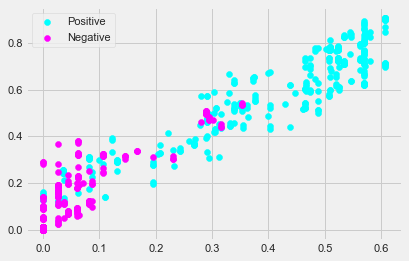

In [39]:
rfc_scale = rfc.feature_importances_
T1D_scaled = T1D_exnan * rfc_scale
all_feat_score = T1D_scaled.sum(axis=1)  
#all_feat_score = T1D_scaled.sum(axis=1)  / len(feat_col)

T1D_mayo = T1D_scaled.loc[:,{'Increased Thirst', 'Increased Urination', 'Increased Hunger', 'Sudden Weight Loss', 'Irritability', 'Weakness', 'Visual Blurring'}]
#T1D_exnan
mayo_feat_score = T1D_mayo.sum(axis=1) 
#mayo_feat_score = T1D_mayo.sum(axis=1)  / len(T1D_mayo.columns)

plt.scatter(mayo_feat_score[diagnosis==1], all_feat_score[diagnosis==1], color='cyan', label='Positive')
plt.scatter(mayo_feat_score[diagnosis==0], all_feat_score[diagnosis==0], color='magenta', label='Negative')
plt.legend()


In [40]:
xtr, xte, ytr, yte = tts(T1D_scaled, np.ravel(diagnosis), test_size=0.2, random_state=7, stratify=np.ravel(diagnosis))

T1D_mayo_tr = xtr.loc[:,{'Increased Thirst', 'Increased Urination', 'Increased Hunger', 'Sudden Weight Loss', 'Irritability', 'Weakness', 'Visual Blurring'}]
T1D_mayo_te = xte.loc[:,{'Increased Thirst', 'Increased Urination', 'Increased Hunger', 'Sudden Weight Loss', 'Irritability', 'Weakness', 'Visual Blurring'}]

all_feat_score_tr = xtr.sum(axis=1)  
all_feat_score_te = xte.sum(axis=1)  

mayo_feat_score_tr = T1D_mayo_tr.sum(axis=1)  
mayo_feat_score_te = T1D_mayo_te.sum(axis=1) 

xtrain = pd.DataFrame(columns=('all', 'mayo'))
xtrain['all'] = all_feat_score_tr
xtrain['mayo'] = mayo_feat_score_tr

xtest = pd.DataFrame(columns=('all', 'mayo'))
xtest['all'] = all_feat_score_te
xtest['mayo'] = mayo_feat_score_te

#scaler = stsc() #standard scaling
#xtr_sc = scaler.fit_transform(xtrain)
#xte_sc = scaler.transform(xtest)

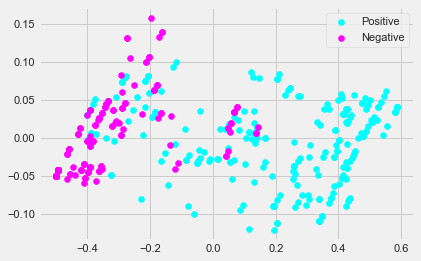

In [41]:
xtr_sc = xtrain
pca = PCA(n_components=2)
pca.fit(xtr_sc)
pca.explained_variance_ratio_
#display(pca.components_)

pca_res = pca.transform(xtr_sc)

plt.scatter(pca_res[ytr==1,0], pca_res[ytr==1,1], color='cyan', label='Positive')
plt.scatter(pca_res[ytr==0,0], pca_res[ytr==0,1], color='magenta', label='Negative')
plt.legend()

**To summarize, we managed to project tha binary data on a single axis which represents them all. we can see that although the sepereation is not perfect, we got pretty nice visual results by making binary data of multiple features spreaded on a single score meter.**